## Geo-location of German Tweets

#### Data Science - Daniel Dutu 

### Data Exploratory

In [28]:
import numpy as np 
import pandas as pd

My data has no header. By default pandas looks in the first row for the header. I have to tell pandas that my data has no header.

In [2]:
train = pd.read_csv("training.txt", header = None)
validation = pd.read_csv("validation.txt", header = None)


#test = pd.read_csv("test.txt", header = None)
# sample_submission = pd.read_csv("/content/sample_submission.txt")

Also, I need to name them.

In [4]:
train.columns = ['id','long','lat','text']
validation.columns = ['id','long','lat','text']

I will combine train and validation into one big training set. 

In [5]:
train_full =pd.concat([train,validation])

Now I need to gain some domain knowledge about the data. 

In [7]:
train_full.head(5)

id       long        lat  \
0  119165  51.810067  10.191331   
1  100377  51.918188  10.599245   
2  109550  52.711074   9.987374   
3  111440  52.386711  11.700612   
4  116670  52.314631   9.701835   

                                                text  
0  Seit d Vase: "Wenn ich kaputt gang, bringt das...  
1  Haha bin au w isch der amig au so richtig lang...  
2  isch d hiltl dachterrasse amne samstig viel bs...  
3  Ich fühle mich wie die Weimarer Republik... .....  
4  Eui liebschte Lunchidee zum Mitneh? 😬 En Grill...

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22583 entries, 0 to 22582
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      22583 non-null  int64  
 1   long    22583 non-null  float64
 2   lat     22583 non-null  float64
 3   text    22583 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 705.8+ KB


In [10]:
train.describe()

id          long           lat
count   22583.000000  22583.000000  22583.000000
mean   111292.000000     51.727377      9.393370
std      6519.294901      0.896464      1.328109
min    100001.000000     48.170000      7.030000
25%    105646.500000     51.002123      7.889091
50%    111292.000000     51.884863      9.650227
75%    116937.500000     52.546918     10.230114
max    122583.000000     53.540000     12.700000

Since Kaggle competition is about MAE / MSE, is a strong indicator that is a regression problem. 
But is best to double check and try to plot the datapoints across Germany map.

**Disclaimer**: I plot the points on the Germany map, but using Google Colab. Apparently on my env there are some weird dependencies issues and I will let here my code from collab and add manualy the plot.

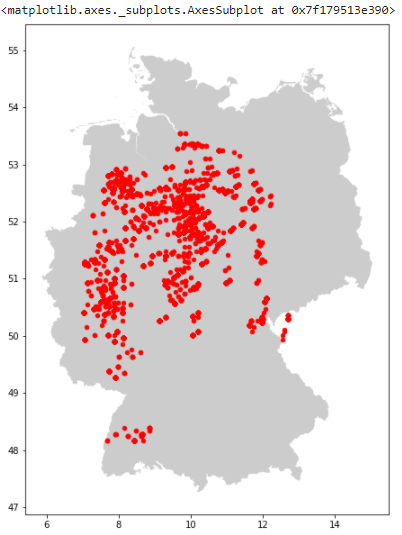

In [27]:
from IPython.display import Image
Image("points_plot.png")

Since there are no visible clusters, now is confirmed that is a regression problem. 

### Data Processing 

#### Derived text features, tweet-based (i.e. simple text features)

In [29]:
def add_derived_features(df, text_source):
    #token count
    df['token_cnt'] = df[ text_source ].apply(lambda x: len(str(x).split(' ')) if ((x is not None) and (x!=np.nan)) else 0)

    # character count
    df['line_size'] = df[ text_source ].apply(lambda x: len(str(x)         )   )  

    # non empty characters
    df['empty_char_cnt'] = df[ text_source ].apply(lambda x: len([c for c in str(x) if c==' '])   )

    # non empty characters
    df['non_empty_char_cnt'] = df[ text_source ].apply(lambda x: len([c for c in str(x) if c!=' '])   )

    #letters only
    df['letter_cnt'] = df[ text_source ].apply(lambda x: len([c for c in str(x) if c.isalpha()])   )

    #special characters only
    df['special_char_cnt'] = df[ text_source ].apply(lambda x: len([c for c in str(x) if (not c.isalnum()) ])   )

    #digits only
    df['digits_cnt'] = df[ text_source ].apply(lambda x: len([c for c in str(x) if c.isnumeric()])   )

    #relative counts
    # non empty characters
    df['empty_char_prct'] = df['empty_char_cnt'] /df['line_size']

    # non empty characters
    df['non_empty_char_prct'] = df['non_empty_char_cnt']/df['line_size']

    #letters only
    df['letter_prct'] = df['letter_cnt'] /df['line_size']

    #special characters only
    df['special_char_prct'] = df['special_char_cnt'] /df['line_size']

    #digits only
    df['digits_prct'] = df['digits_cnt']/df['line_size']


    # catergories absolute count
    df['is_alpha_cnt'] =df[ text_source ].apply(lambda x: len([t for t in str(x).split(' ') if t.isalpha() ] ))
    df['is_mixed_alnum_cnt'] =df[ text_source ].apply(lambda x: len([t for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())] ))
    df['is_numeric_cnt'] =df[ text_source ].apply(lambda x: len([t for t in str(x).split(' ') if t.isnumeric() ] ))
    df['is_non_alnum_cnt'] =df[ text_source ].apply(lambda x: len( str(x).split(' ')  )-\
                                            len([t for t in str(x).split(' ') if t.isalnum() ] ))
    # categories relative count
    df['is_alpha_prct'] =df['is_alpha_cnt']/df['token_cnt']
    df['is_numeric_prct'] =df['is_numeric_cnt']/df['token_cnt']
    df['is_mixed_alnum_prct'] =df['is_mixed_alnum_cnt']/df['token_cnt']
    df['is_non_alnum_prct'] =df['is_non_alnum_cnt']/df['token_cnt']

    for c in ['is_alpha_prct','is_numeric_prct','is_mixed_alnum_prct','is_non_alnum_prct']:
        df[c] = df[c].replace(np.inf, 2)
        df[c] = df[c].replace(np.nan, -1)
    # max and min token length by category; mean and std for lengths

    # max
    df['is_alpha_max_len'] =df[ text_source ].apply(lambda x: max([len(t) for t in str(x).split(' ') if t.isalpha() ] ) if\
                                                len([t for t in str(x).split(' ') if t.isalpha()])>0 else -1)
    df['is_numeric_max_len'] =df[ text_source ].apply(lambda x: max([len(t) for t in str(x).split(' ') if t.isnumeric() ] )if\
                                                len([t for t in str(x).split(' ') if t.isnumeric()])>0 else -1)
    df['is_mixed_alnum_max_len'] =df[ text_source ].apply(lambda x: max([len(t) for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())] )if\
                                                len([t for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())])>0 else -1)

    df['is_non_alnum_max_len'] =df[ text_source ].apply(lambda x: max([len(t) for t in str(x).split(' ') if (not t.isalnum())] )if\
                                                len([t for t in str(x).split(' ') if (not t.isalnum())])>0 else -1)

    # min
    df['is_alpha_min_len'] =df[ text_source ].apply(lambda x: min([len(t) for t in str(x).split(' ') if t.isalpha() ] ) if\
                                                len([t for t in str(x).split(' ') if t.isalpha()])>0 else -1)
    df['is_numeric_min_len'] =df[ text_source ].apply(lambda x: min([len(t) for t in str(x).split(' ') if t.isnumeric() ] )if\
                                                len([t for t in str(x).split(' ') if t.isnumeric()])>0 else -1)
    df['is_mixed_alnum_min_len'] =df[ text_source ].apply(lambda x: min([len(t) for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())] )if\
                                                len([t for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())])>0 else -1)

    df['is_non_alnum_min_len'] =df[ text_source ].apply(lambda x: min([len(t) for t in str(x).split(' ') if (not t.isalnum())] )if\
                                                len([t for t in str(x).split(' ') if (not t.isalnum())])>0 else -1)

    # avg len
    df['is_alpha_avg_len'] =df[ text_source ].apply(lambda x: np.mean([len(t) for t in str(x).split(' ') if t.isalpha() ] ) if\
                                                len([t for t in str(x).split(' ') if t.isalpha()])>0 else -1)
    df['is_numeric_avg_len'] =df[ text_source ].apply(lambda x: np.mean([len(t) for t in str(x).split(' ') if t.isnumeric() ] )if\
                                                len([t for t in str(x).split(' ') if t.isnumeric()])>0 else -1)
    df['is_mixed_alnum_avg_len'] =df[ text_source ].apply(lambda x: np.mean([len(t) for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())] )if\
                                                len([t for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())])>0 else -1)

    df['is_non_alnum_avg_len'] =df[ text_source ].apply(lambda x: np.mean([len(t) for t in str(x).split(' ') if (not t.isalnum())] )if\
                                                len([t for t in str(x).split(' ') if (not t.isalnum())])>0 else -1)

    # std for len
    df['is_alpha_std_len'] =df[ text_source ].apply(lambda x: np.std([len(t) for t in str(x).split(' ') if t.isalpha() ] ) if\
                                                len([t for t in str(x).split(' ') if t.isalpha()])>0 else -1)
    df['is_numeric_std_len'] =df[ text_source ].apply(lambda x: np.std([len(t) for t in str(x).split(' ') if t.isnumeric() ] )if\
                                                len([t for t in str(x).split(' ') if t.isnumeric()])>0 else -1)
    df['is_mixed_alnum_std_len'] =df[ text_source ].apply(lambda x: np.std([len(t) for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())] )if\
                                                len([t for t in str(x).split(' ') if t.isalnum() and\
                                                                     (not t.isalpha()) and (not t.isnumeric())])>0 else -1)

    df['is_non_alnum_std_len'] =df[ text_source ].apply(lambda x: np.std([len(t) for t in str(x).split(' ') if (not t.isalnum())] )if\
                                                len([t for t in str(x).split(' ') if (not t.isalnum())])>0 else -1)

add_derived_features(train_full, 'text')

In [30]:
train_full.shape

(25627, 40)

In [31]:
train_cols = [c for c in train_full.columns if c not in ['id','long','lat']]

### Clear Emoji

In [33]:
#!pip install emoji

import functools
import operator
import re

import emoji

def clear_emoji(x):
    em_split_emoji = emoji.get_emoji_regexp().split(x)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)
    return ' '.join([c for c in em_split if c not in emoji.UNICODE_EMOJI])

train_full.text = train_full.text.apply(clear_emoji)

Small overview to check the difference 

In [34]:
train.head().text[0]

'Seit d Vase: "Wenn ich kaputt gang, bringt das 1 Jahr Unglück." Antwortet de Spiegel: "Das isch doch gar nüt. Wenn ich kaputt gang, bringt das 7 Jahr Pech!" Dadruf fangt s Kondom a lache. S\'Atomkraftwerk au 😋 Uuuh nöd schlecht 👍 seisch anere frau sie isch fett und du hesch dis lebe lang unglück (au wenn i dem fall nüm lang lebsch)'

In [35]:
train_full.head().text[0]

'Seit d Vase: "Wenn ich kaputt gang, bringt das 1 Jahr Unglück." Antwortet de Spiegel: "Das isch doch gar nüt. Wenn ich kaputt gang, bringt das 7 Jahr Pech!" Dadruf fangt s Kondom a lache. S\'Atomkraftwerk au Uuuh nöd schlecht seisch anere frau sie isch fett und du hesch dis lebe lang unglück (au wenn i dem fall nüm lang lebsch)'

### Data Modelling 

Split multiple times in train and test
For now I split once, setting the random_state so that if I want to work later everything is traceable.

Once the model is found, I repeat this split and the training say 100 times, with random_state eliminated so that the splits are independent and not repeatable.

In [36]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(train_full[train_cols], train_full[['long','lat']], test_size=0.2, 
                                                    random_state=7) # this will have to stay loose if we want to properly
                                                                     # evaluate the model performance and split several time
print(train_full.shape[1], X_train.shape[1],X_test.shape[1])

40 37 37


#### Part of feature engineering I need to add text features

In [37]:
# !pip install nltk
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Daniel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
import nltk


#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features =1000, # max words for 'vocabulary' - to run this eg. 
                             max_df = 0.3, # max frequency for words in vocabulary 
                             min_df = 0.001, # min frequency for words in vocabulary
                             token_pattern  = '[a-zA-Z]{3,20}', #just look for words at least 3 char long and no more than 20
                             smooth_idf = True, 
                             #binary = True,
                             stop_words = german_stop_words # german stop words loaded - not sure how efficient this is but worth trying
                                  )

# applies the fit_transform on the training set and the transform on the test set
def add_text_features(df_train,df_test):

    X_train_tfidf = vectorizer.fit_transform(df_train['text'])
     
    print("Train Vectorized Shape: ", X_train_tfidf.shape)

    X_test_tfidf = vectorizer.transform(df_test['text'])
    print("Test Vectorized Shape: ", X_test_tfidf.shape)
    
    #### Adding sparse data series from vectorization as columns in dataframe
    for i, col in enumerate(vectorizer.get_feature_names()):
        
        #x = pd.Series(pd.array.Sparse(X_train_tfidf[:, i].toarray().ravel()))
        if col in df_train.columns:
            df_train.drop(columns = [col],inplace = True)
        if col in df_test.columns:
            df_test.drop(columns = [col],inplace = True)
        df_train.loc[:,col] = X_train_tfidf[:, i].toarray()
        df_test[col] = X_test_tfidf[:, i].toarray()

This is the final thing to be used - but first cross validation; inside the cross validation need to add features to splits
the same need to be done when training on this below...


In [39]:
X = X_train[[c for c in X_train.columns if c !='text']].to_numpy()
y= y_train.to_numpy()

X_eval = X_test[[c for c in X_test.columns if c !='text']].to_numpy()
y_eval = y_test.to_numpy()

### Fitting Random Forest Regression to the dataset

Overfitting is controlled by max_samples.

I can play with the word freq and max samples to tune the algorithm. the estimators might not play a big role, although when max_samples is small, than up to some point we want to add estimators in order to explore the entire data set with as many disjoint opinions (from estimators for which the training set is not overlapping)

In [42]:
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [40]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators =100, 
                                  criterion = "mae",
                                  max_samples =0.1,
                                  n_jobs = 4,
                                  random_state = 0)

In [44]:
import copy

# make a hard copy of the X_train to avoid messing up with the cross-validation if a cross-validation was used
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# add text features (vectorization) - that is prepare the train and test features
add_text_features(X_train_orig,X_test_orig)

# convert to numpy arrays
X = X_train_orig[[c for c in X_train_orig.columns if c !='text']].to_numpy()
y= y_train.to_numpy()

X_eval = X_test_orig[[c for c in X_test_orig.columns if c !='text']].to_numpy()
y_eval = y_test.to_numpy()

# set up the regressor and fit on big training set
regressor.max_features =int(round(X.shape[1]*0.33,0))
regressor.fit(X,y)

# predict on train and test
y_hat_fit = regressor.predict(X)
y_hat_eval = regressor.predict(X_eval)



Train Vectorized Shape:  (20501, 1000)
Test Vectorized Shape:  (5126, 1000)


In [47]:
print("MAE on train (fitting error):",mean_absolute_error(y_true = y, y_pred = y_hat_fit))
print("MAE on validation:",mean_absolute_error(y_true = y_eval, y_pred = y_hat_eval))
print('-----------------------------------------------------------------------------------')
print("MSE on train (fitting error):",mean_squared_error(y_true = y, y_pred = y_hat_fit))
print("MSE on validation:",mean_squared_error(y_true = y_eval, y_pred = y_hat_eval))

MAE on train (fitting error): 0.6440050142568499
MAE on validation: 0.7095226580561811
-----------------------------------------------------------------------------------
MSE on train (fitting error): 0.7379147331220408
MSE on validation: 0.8857269051369241


#### Predicted vs Actuals 

In [48]:
import plotly.graph_objects as go

fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=[ e[0] for e in y], y=[ e[1] for e in y],
                    mode='markers',
                    name='ytrain'))
fig.add_trace(go.Scatter(x=[ e[0] for e in y_hat_fit], y=[ e[1] for e in y_hat_fit],
                    mode='markers',
                    name='ytrain_pred'))
fig.add_trace(go.Scatter(x=[ e[0] for e in y_eval], y=[ e[1] for e in y_eval],
                    mode='markers',
                    name='ytest'))
fig.add_trace(go.Scatter(x=[ e[0] for e in y_hat_eval], y=[ e[1] for e in y_hat_eval],
                    mode='markers',
                    name='ytest_pred'))

fig.show()

### Submission part 

In [49]:
test = pd.read_csv("test.txt", header = None)
test.columns = ['id','text']

Since there is a submission sample, I will try to respect the format

In [50]:
ids = test.id
test = test[['text']]

Also need to apply the same feature engineering to the real unseen data. 

In [51]:
add_derived_features(test, 'text')

In [52]:
test.text = test.text.apply(clear_emoji)
test

text  token_cnt  line_size  \
0     min vibi funktionkert nöd... hesch d'batterie ...         14         95   
1     Ich: Also langsam söti scho schlafe Au Ich: He...         75        433   
2     Hez hie ou lüt wo dr ganz tag ine biudschirm m...         94        600   
3     je neui wohnig neua job eigeni kuchi aber mir ...         41        230   
4     Schön wies grad chunt cho hagle u du nid d müg...        106        513   
...                                                 ...        ...        ...   
3133  Lüt woni nöd gern han: 15-jährigi Schwiizer wo...         89        532   
3134  Wo si dguetzli? Die hett de David. Wo isch de ...         24        125   
3135  ich kuschle 2-3 mol ih de woche met mim maa ec...         25        118   
3136  Cha mir öbert sägä wie ich möglichst gli die 1...         16         85   
3137  Es nervt mi, dass Koffer wo a ganzes Abteil in...        100        560   

      empty_char_cnt  non_empty_char_cnt  letter_cnt  special_char_cnt  \
0                 13                  82          70                25   
1                 74                 359         350                83   
2                 93                 507         491               109   
3                 40                 190         177                53   
4                105                 408         379               131   
...              ...                 ...         ...               ...   
3133              88                 444         415               104   
3134              23                 102          96                29   
3135              24                  94          87                29   
3136              15                  70          65                18   
3137              99                 461         432               124   

      digits_cnt  empty_char_prct  non_empty_char_prct  ...  \
0              0         0.136842             0.863158  ...   
1              0         0.170901             0.829099  ...   
2              0         0.155000             0.845000  ...   
3              0         0.173913             0.826087  ...   
4              3         0.204678             0.795322  ...   
...          ...              ...                  ...  ...   
3133          13         0.165414             0.834586  ...   
3134           0         0.184000             0.816000  ...   
3135           2         0.203390             0.796610  ...   
3136           2         0.176471             0.823529  ...   
3137           4         0.176786             0.823214  ...   

      is_mixed_alnum_min_len  is_non_alnum_min_len  is_alpha_avg_len  \
0                         -1                     4          4.714286   
1                         -1                     3          4.287879   
2                         -1                     1          4.962963   
3                         -1                     1          4.580645   
4                         -1                     1          3.673913   
...                      ...                   ...               ...   
3133                      -1                     2          4.337838   
3134                      -1                     4          3.750000   
3135                      -1                     3          3.681818   
3136                      -1                     3          4.384615   
3137                       3                     1          4.425000   

      is_numeric_avg_len  is_mixed_alnum_avg_len  is_non_alnum_avg_len  \
0                   -1.0                    -1.0              7.000000   
1                   -1.0                    -1.0              8.444444   
2                   -1.0                    -1.0              8.076923   
3                   -1.0                    -1.0              4.800000   
4                   -1.0                    -1.0              5.000000   
...                  ...                     ...                   ...   
3133                 2.0                    -1.0 

In [54]:
X_test_tfidf_real = vectorizer.transform(test['text'])
print("Test Vectorized Shape: ", X_test_tfidf_real.shape)

Test Vectorized Shape:  (3138, 1000)


In [55]:
for i, col in enumerate(vectorizer.get_feature_names()):
        
        if col in test.columns:
            test.drop(columns = [col],inplace = True)
        test[col] = X_test_tfidf_real[:, i].toarray()

In [56]:
test.head(5)

text  token_cnt  line_size  \
0  min vibi funktionkert nöd... hesch d'batterie ...         14         95   
1  Ich: Also langsam söti scho schlafe Au Ich: He...         75        433   
2  Hez hie ou lüt wo dr ganz tag ine biudschirm m...         94        600   
3  je neui wohnig neua job eigeni kuchi aber mir ...         41        230   
4  Schön wies grad chunt cho hagle u du nid d müg...        106        513   

   empty_char_cnt  non_empty_char_cnt  letter_cnt  special_char_cnt  \
0              13                  82          70                25   
1              74                 359         350                83   
2              93                 507         491               109   
3              40                 190         177                53   
4             105                 408         379               131   

   digits_cnt  empty_char_prct  non_empty_char_prct  ...  ziit  zimmer  zit  \
0           0         0.136842             0.863158  ...   0.0     0.0  0.0   
1           0         0.170901             0.829099  ...   0.0     0.0  0.0   
2           0         0.155000             0.845000  ...   0.0     0.0  0.0   
3           0         0.173913             0.826087  ...   0.0     0.0  0.0   
4           3         0.204678             0.795322  ...   0.0     0.0  0.0   

   zom  zrugg  ztue  zue  zug  zwei  zyt  
0  0.0    0.0   0.0  0.0  0.0   0.0  0.0  
1  0.0    0.0   0.0  0.0  0.0   0.0  0.0  
2  0.0    0.0   0.0  0.0  0.0   0.0  0.0  
3  0.0    0.0   0.0  0.0  0.0   0.0  0.0  
4  0.0    0.0   0.0  0.0  0.0   0.0  0.0  

[5 rows x 1037 columns]

In [57]:
X_eval_real = test[[c for c in test.columns if c !='text']].to_numpy()
X_eval_real.shape

(3138, 1036)

In [58]:
y_hat_eval_real = regressor.predict(X_eval_real)

In [59]:
y_hat_eval_real

array([[51.71934932,  9.87922753],
       [51.95189051,  9.64177388],
       [50.91219294,  7.89387153],
       ...,
       [51.35691751,  9.35930603],
       [51.63201831,  9.60633947],
       [51.01641103, 10.09857847]])

In [61]:
submission= pd.DataFrame(data=y_hat_eval_real, columns=["lat", "long"])
submission['id'] = ids
submission[['id','lat','long']]

id        lat       long
0     300121  51.719349   9.879228
1     302441  51.951891   9.641774
2     300266  50.912193   7.893872
3     300911  51.000410  11.226957
4     302681  50.843317   7.969476
...      ...        ...        ...
3133  300151  52.061300  10.138823
3134  300302  51.664729   9.608612
3135  301963  51.356918   9.359306
3136  302180  51.632018   9.606339
3137  301697  51.016411  10.098578

[3138 rows x 3 columns]

In [62]:
filename = 'German_Tweets_RF.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: German_Tweets_RF.csv


--- 

### From now on there is a playground where I tested different approaches of algorithms.

So I looked up for other MultiOutputRegressions so I tried **xgboost** 

In [64]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:linear')).fit(X, y)

[19:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[19:03:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


In [65]:
y_xgboost_fit = multioutputregressor.predict(X)
y_xgboost_eval = multioutputregressor.predict(X_eval)

In [66]:
print("MAE on train (fitting error):",mean_absolute_error(y_true = y, y_pred = y_xgboost_fit))
print("MAE on validation:",mean_absolute_error(y_true = y_eval, y_pred = y_xgboost_eval))
print('-----------------------------------------------------------------------------------')
print("MSE on train (fitting error):",mean_squared_error(y_true = y, y_pred = y_xgboost_fit))
print("MSE on validation:",mean_squared_error(y_true = y_eval, y_pred = y_xgboost_eval))

MAE on train (fitting error): 0.5690827949587962
MAE on validation: 0.6901071857799159
-----------------------------------------------------------------------------------
MSE on train (fitting error): 0.5659269241906815
MSE on validation: 0.8220698865208849


Apparently XGBoost performed better than RF. 
But as far as I know, xgboost doesnt have something truly multidim and it optimises on every dimension. 
Maybe by modifying the learning rate the result could have been better.

---

### Other MultiOutputRegression methods. 

In [67]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import MultiOutputRegressor

In [68]:
# Prepare a dictionary of estimators after instantiating each one of them
ESTIMATORS = {
    "Extra trees": ExtraTreesRegressor(n_estimators=10,
                                       max_features=32,     # Out of 20000
                                       random_state=0),
    "K-nn": KNeighborsRegressor(),                          # Accept default parameters
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(random_state=0),
    "Decision Tree Regressor":DecisionTreeRegressor(max_depth=5),
    "MultiO/P GBR" :MultiOutputRegressor(GradientBoostingRegressor(n_estimators=5)),
    "MultiO/P AdaB" :MultiOutputRegressor(AdaBoostRegressor(n_estimators=5))
}

In [73]:
y_test_predict_fit = dict()
y_test_predict_eval = dict()

y_mse_fit = dict()
y_mse_eval = dict()
y_mae_fit = dict()
y_mae_eval = dict()

for name, estimator in ESTIMATORS.items():     
    estimator.fit(X, y)                   
    
    y_test_predict_fit[name] = estimator.predict(X)   # Make predictions and save it in dict under key: name
    y_test_predict_eval[name] = estimator.predict(X_eval)
    
    y_mse_fit[name] = mean_squared_error(y, estimator.predict(X))
    y_mse_eval[name] = mean_squared_error(y_eval, estimator.predict(X_eval))
    
    y_mae_fit[name] = mean_absolute_error(y, estimator.predict(X))
    y_mae_eval[name] = mean_absolute_error(y_eval, estimator.predict(X_eval))
    
    print('MSE for ',name,' is ',y_mse_fit[name],'train')
    print('MSE for ',name,' is ',y_mse_eval[name],'validation')
    print('---')
    print('MAE for ',name,' is ',y_mse_fit[name],'train')
    print('MAE for ',name,' is ',y_mae_eval[name],'validation')
    print('--------------------------------------------------')
    


MSE for  Extra trees  is  3.441505263808492e-29 train
MSE for  Extra trees  is  0.8876779132141164 validation
---
MAE for  Extra trees  is  3.441505263808492e-29 train
MAE for  Extra trees  is  0.7172950073111652 validation
--------------------------------------------------
MSE for  K-nn  is  0.9963508959035158 train
MSE for  K-nn  is  1.4957769024543097 validation
---
MAE for  K-nn  is  0.9963508959035158 train
MAE for  K-nn  is  0.9806441809076623 validation
--------------------------------------------------
MSE for  Linear regression  is  0.7485709510579857 train
MSE for  Linear regression  is  0.8029094282870745 validation
---
MAE for  Linear regression  is  0.7485709510579857 train
MAE for  Linear regression  is  0.688517662328613 validation
--------------------------------------------------
MSE for  Ridge  is  0.7470889299199195 train
MSE for  Ridge  is  0.7976543333821119 validation
---
MAE for  Ridge  is  0.7470889299199195 train
MAE for  Ridge  is  0.6863425976748383 validatio

Those were all for fun. Main stuff is above.